In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils #pywt tsfresh
import features.preprocessing as pre

# TODO Wavelets

## Basic EDA

[paper](https://arxiv.org/abs/1909.09347)

In [2]:
""" Given a resolution, the following computes the number of smaples in each chunk. """
fs = 16000 #[Hz]
res = 5 #[Hz]
n = fs//res# [Num. samples in time domain for each chunk] (make next lowest power of 2)
n

3200

In [3]:
# Read data
df = utils.indexFiles(filePath = './data')

# Get ID of the closest mic to the corresponding machine_type
df['closest_mic'] = df['machine_type'].map({'valve': 0, 'pump': 2, 'fan': 4,'slider': 6})

df.head(5)

filepath  machine_id machine_type   
0  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan  \
1  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
2  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
3  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
4  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   

  background_noise    target  closest_mic  
0            -6_dB  abnormal            4  
1            -6_dB  abnormal            4  
2            -6_dB  abnormal            4  
3            -6_dB  abnormal            4  
4            -6_dB  abnormal            4

### Number of samples and class balance per machine

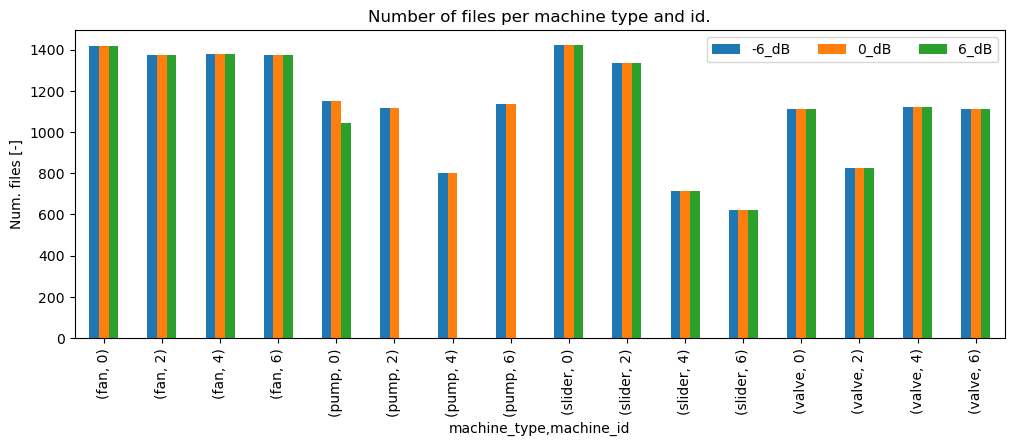

In [4]:
df.groupby(by = ['machine_type', 'machine_id', 'background_noise']).\
nunique()['filepath'].\
unstack().\
plot.bar(
    figsize = (12, 4),
    ylabel = 'Num. files [-]',
    title = 'Number of files per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

* 4 machine types (fan, pump, slider, valve)
* 4 machines per type (id 0, 2, 4, 6)
* 3 (well-balanced) background noise levels for each machine type/id (apart from pumps 2, 4, 6 which miss '6dB' background noise levels)

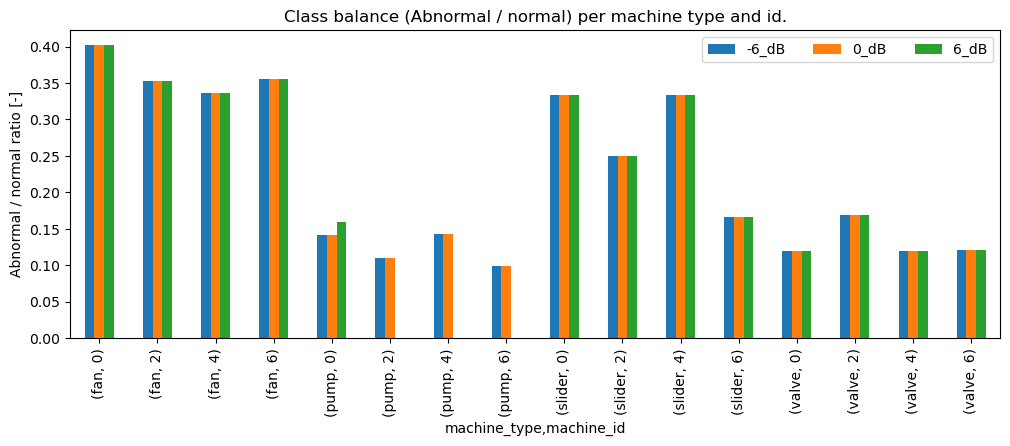

In [5]:
groups = df.groupby(by = ['machine_type', 'machine_id', 'background_noise', 'target']).\
nunique()['filepath'].\
unstack()

groups['class_balance'] = groups['abnormal'] / groups['normal']

groups['class_balance'].\
unstack().\
plot.bar(
    figsize = (12, 4),
    ylabel = 'Abnormal / normal ratio [-]',
    title = 'Class balance (Abnormal / normal) per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

Only the fans and some sliders are well-balanced. Nothing extreme though.

### Recordings

Sample waveforms that will be classified:


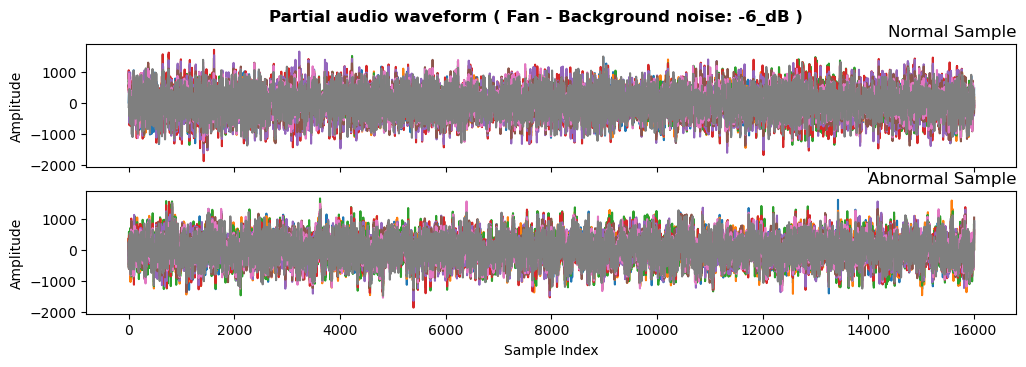

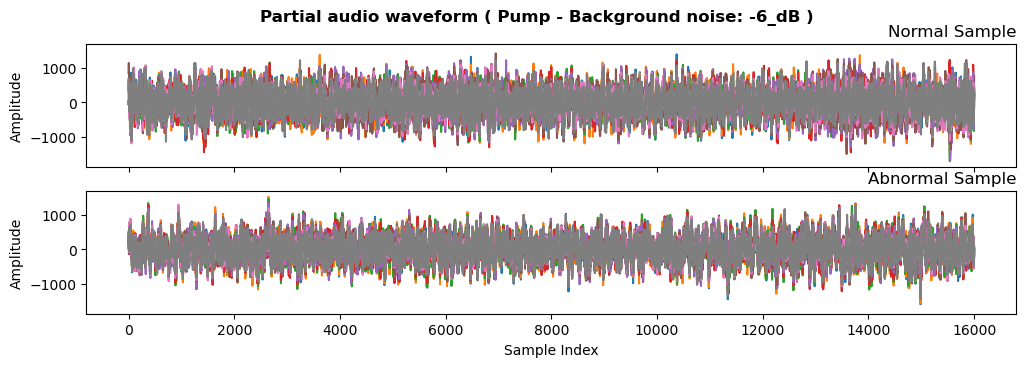

In [6]:
numPlots = 2

backNoise  = '-6_dB'
machine_id = '0'
numSamples = 16000 # Entire record is too large to be plotted
curPlot   = 0

for group, data in df.groupby(['machine_type']):

    normal   = data[(data['target'] == 'normal')   & (data['background_noise'] == backNoise)].sample()
    abnormal = data[(data['target'] == 'abnormal') & (data['background_noise'] == backNoise)].sample()

    normalFile   = normal.values[0][0]
    abnormalFile = abnormal.values[0][0]

    _, normalAudio   = utils.readWav(normalFile)
    _, abnormalAudio = utils.readWav(abnormalFile)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 3.5), sharex=True, sharey=True)
    ax[0].plot(normalAudio[0:numSamples, :])
    ax[0].set_ylabel('Amplitude')
    ax[0].set_title('Normal Sample', loc = 'right')

    ax[1].plot(abnormalAudio[0:numSamples, :])
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_title('Abnormal Sample', loc = 'right')

    t = f'Partial audio waveform ( {group[0].title()} - Background noise: {backNoise} )'
    plt.suptitle(t, weight = 'bold');
    curPlot += 1

    if curPlot == numPlots: break

## Feature extractor

* Time-domain features
    * Mean
    * Standard Deviation
    * Skewness
    * Kurtosis
    * Root-Mean-Square (RMS) value
    * Peak value
    * Shape factor
    * Crest factor
    * Impulse factor
    * Clearance factor
* Frequency-domain features
    * Location (frequency, amplitude) of the highest peak in each band of the frequency spectrume in 1/3 octave band

Steps for FFT:
* Sliding window
* Detrending
* FFT in each chunk
* FFT level average


The microphones record 16bit signed integers (range from -32768 to 32767). They probably represent a 16-bit digitalization of the electrical output from 0-100% maximum voltage range of the microphone.

This value does correlate to sound pressure in Pascal, but it is not Pascal.


In [7]:
import features
import utils

sampleFrequency, signal = utils.readWav(normalFile, signalType = 'float')
feats = features.extract(signal, sampleFrequency)
feats.shape, signal.shape

((199, 8), (160000, 8))

In [30]:
df = utils.indexFiles('./data/-6_dB_fan')

for _, dfChunk in df.groupby(np.arange(len(df)) // 10):
    
    signals = []
    for f in dfChunk['filepath'].values:
        sampleFrequency, signal = utils.readWav(f, signalType = 'float')
        signals.append(signal)

    break

In [31]:
signals = np.stack(signals, axis = 2)
signals.shape

(160000, 8, 10)

In [29]:
feats = features.extract(signals, sampleFrequency, axis = 0)
feats.shape, signals.shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 10 and the array at index 1 has size 8

In [50]:
"""
from signals import signal1, signal2
import matplotlib.pyplot as plt
import numpy as np

sampleFrequency = 8000
time            = 10
numSamples      = time * sampleFrequency
sig1            = signal1(f0 = 220, noise = 0.22, N = numSamples, fs = sampleFrequency)
sig2            = signal2(f0 = 200, noise = 0.1, N = numSamples, fs = sampleFrequency)

sig1 = sig1 * np.linspace(0.1, 10, sig1.shape[0])
sig1 = sig1 * np.linspace(5, 0.5, sig1.shape[0])
sig1[0:sampleFrequency* 10] *= 10
signal          = np.stack([sig1, sig2], axis = -1)

plt.figure(figsize = (15, 3))
plt.plot(signal[:int(sampleFrequency * 0.05), ...])
print(signal.shape)
"""

'\nfrom signals import signal1, signal2\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nsampleFrequency = 8000\ntime            = 10\nnumSamples      = time * sampleFrequency\nsig1            = signal1(f0 = 220, noise = 0.22, N = numSamples, fs = sampleFrequency)\nsig2            = signal2(f0 = 200, noise = 0.1, N = numSamples, fs = sampleFrequency)\n\nsig1 = sig1 * np.linspace(0.1, 10, sig1.shape[0])\nsig1 = sig1 * np.linspace(5, 0.5, sig1.shape[0])\nsig1[0:sampleFrequency* 10] *= 10\nsignal          = np.stack([sig1, sig2], axis = -1)\n\nplt.figure(figsize = (15, 3))\nplt.plot(signal[:int(sampleFrequency * 0.05), ...])\nprint(signal.shape)\n'

TODO: 
* Continue the pipeline from the book

check these for another pipeline
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

check librosa for feature extraction
* https://librosa.org/doc/main/_modules/librosa/feature/spectral.html#rms